In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from __future__ import division

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
def gen_arma(ar=[], ma=[], N=1000, mu=0):
    
    p, q = map(len, [ar, ma])
    ar, ma = map(np.array, [ar[::-1], ma[::-1]])
    
    max_order = max(p, q)
    
    wn = np.random.normal(0, 1, N + max_order)
    ts = np.ones(N + max_order) * mu
    
    for i in range(N):
        
        idx = i + max_order
        ts[idx] = wn[idx] + np.dot(ts[idx - p:idx], ar) + np.dot(wn[idx - q:idx], ma)
    
    return ts[max_order:]

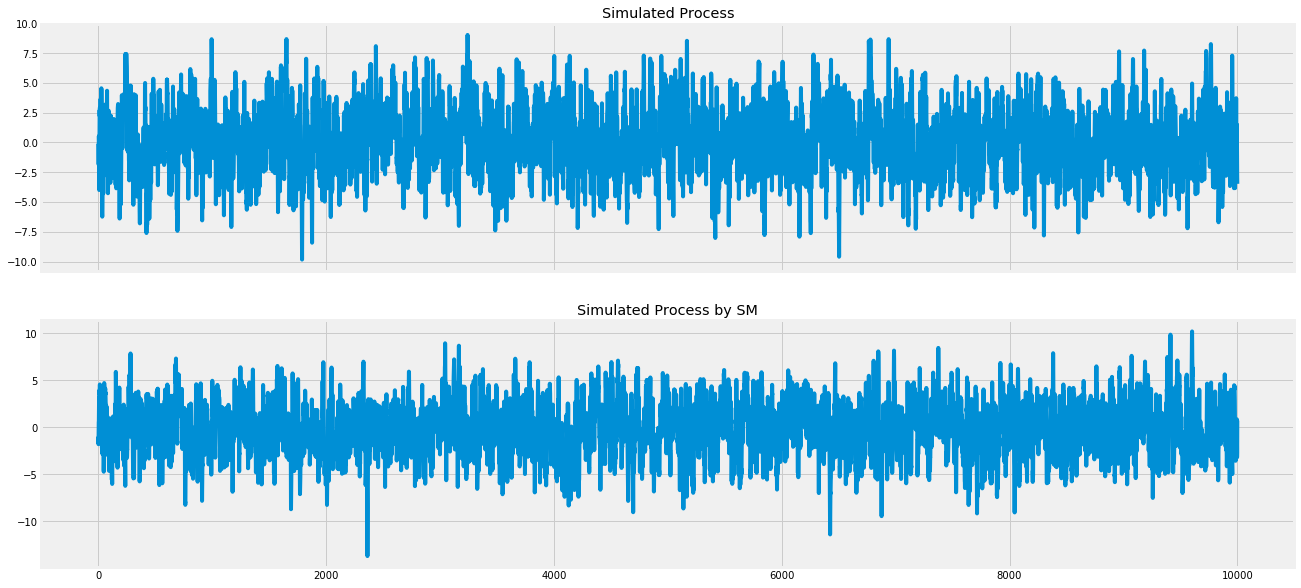

In [3]:
T = 10000
ar_coef = [0.8]
ma_coef = [0.7]

y_jc = gen_arma(ar_coef, ma_coef, T)
y_sm = sm.tsa.ArmaProcess(-np.array([-1] + ar_coef), [1] + ma_coef).generate_sample(T)

fig, ax = plt.subplots(2,1, sharex=True, figsize=(20,10))
ax[0].plot(range(T), y_jc)
ax[1].plot(range(T), y_sm)

ax[0].set_title('Simulated Process')
ax[1].set_title('Simulated Process by SM')

In [4]:
def OLS(Y, X, const=True):
    Y = np.array(Y)
    X = np.c_[np.ones(np.shape(Y)),np.array(X)] if const else np.array(X)
    
    cov = np.dot(np.transpose(X),Y)
    var = np.dot(np.transpose(X),X)
    
    b = np.dot(np.linalg.inv(var), cov)
    return b if b.shape!=(1,1) else float(b)

def AR_data_preprocess(TS, ar_lag=1):
    
    Y = np.array(TS[ar_lag:])
    Y = Y.reshape(len(Y),1)
    X = np.r_[map(lambda i: TS[ar_lag-i-1:-i-1], range(ar_lag))].T
    
    return Y, X

In [16]:
def get_IV_est(Y):
    
    y, x = AR_data_preprocess(Y, 2)
    z = x[:,1]
    x = x[:,0]   
    return float(z.T.dot(y) / z.T.dot(x))

def get_OLS_est(Y):
    
    y, X = AR_data_preprocess(Y, 1)
    return OLS(y, X, False)

In [17]:
estimate = map(lambda s: (get_OLS_est(s), get_IV_est(s)), [gen_arma(ar_coef, ma_coef, T) for i in range(10000)])
estimate_OLS = [e[0] for e in estimate]
estimate_IV = [e[1] for e in estimate]

Mean of Beta: 0.896512463726


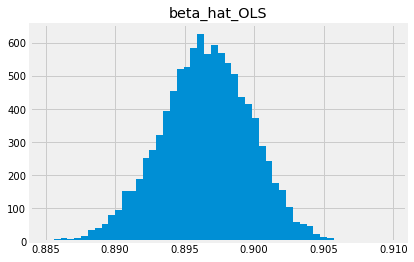

In [18]:
m_beta = np.mean(estimate_OLS)

print 'Mean of Beta:', m_beta
    
plt.hist(estimate_OLS,bins=50)
plt.title('beta_hat_OLS')

Mean of Beta: 0.799859164785


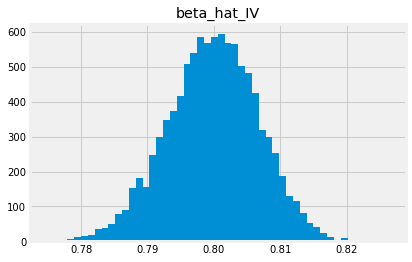

In [19]:
m_IV = np.mean(estimate_IV)

print 'Mean of Beta:', m_IV
    
plt.hist(estimate_IV, bins=50)
plt.title('beta_hat_IV')

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                     ARMA(1, 0)   Log Likelihood              -15959.758
Method:                       css-mle   S.D. of innovations              1.194
Date:                Mon, 17 Apr 2017   AIC                          31923.516
Time:                        23:59:34   BIC                          31937.937
Sample:                             0   HQIC                         31928.397
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.y        0.8923      0.005    197.789      0.000         0.884     0.901
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1206           +0.0000j            1.1206            0.0000
-----------------------------------------------------------------------------
"""

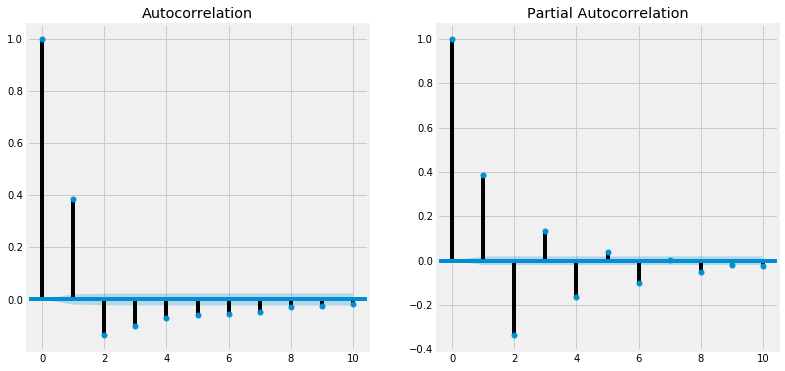

In [21]:
arma_model = sm.tsa.ARMA(y_jc, order=(1,0))

ests = arma_model.fit(maxiter=500, trend='nc')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sm.tsa.graphics.plot_acf(ests.resid, lags=10, ax=axes[0])
sm.tsa.graphics.plot_pacf(ests.resid, lags=10, ax=axes[1])
ests.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                     ARMA(1, 0)   Log Likelihood              -16016.576
Method:                       css-mle   S.D. of innovations              1.200
Date:                Mon, 17 Apr 2017   AIC                          32037.152
Time:                        23:59:43   BIC                          32051.573
Sample:                             0   HQIC                         32042.033
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.y        0.8970      0.004    203.132      0.000         0.888     0.906
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1148           +0.0000j            1.1148            0.0000
-----------------------------------------------------------------------------
"""

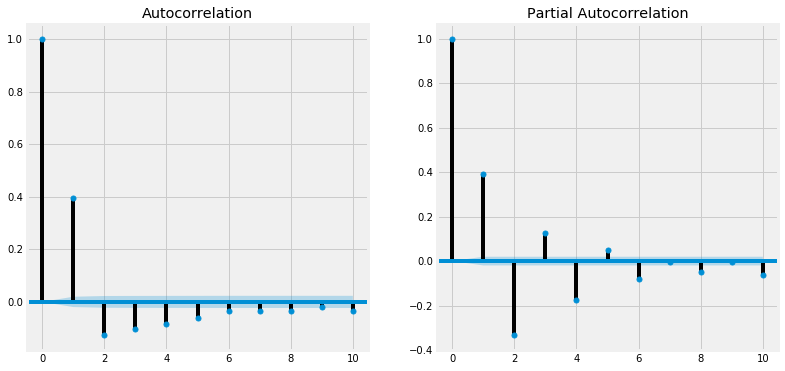

In [22]:
arma_model = sm.tsa.ARMA(y_sm, order=(1,0))

ests = arma_model.fit(maxiter=500, trend='nc')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sm.tsa.graphics.plot_acf(ests.resid, lags=10, ax=axes[0])
sm.tsa.graphics.plot_pacf(ests.resid, lags=10, ax=axes[1])
ests.summary()